# Post-training integer quantization

## Overview

Integer quantization is an optimization strategy that converts 32-bit floating-point numbers (such as weights and activation outputs) to the nearest 8-bit fixed-point numbers. This results in a smaller model and increased inferencing speed, which is valuable for low-power devices such as the [OpenMV](https://openmv.io) camera

## Setup

In order to quantize both the input and output tensors, we need to use APIs added in TensorFlow 2.3:

In [1]:
import os
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Generate a TensorFlow Model

We'll build a simple model to classify a few playing cards.

Found 97 files belonging to 5 classes.
Using 78 files for training.


I0000 00:00:1726358197.543763  183705 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726358197.584603  183705 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726358197.584822  183705 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726358197.586361  183705 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 97 files belonging to 5 classes.
Using 19 files for validation.
number of classes: 5


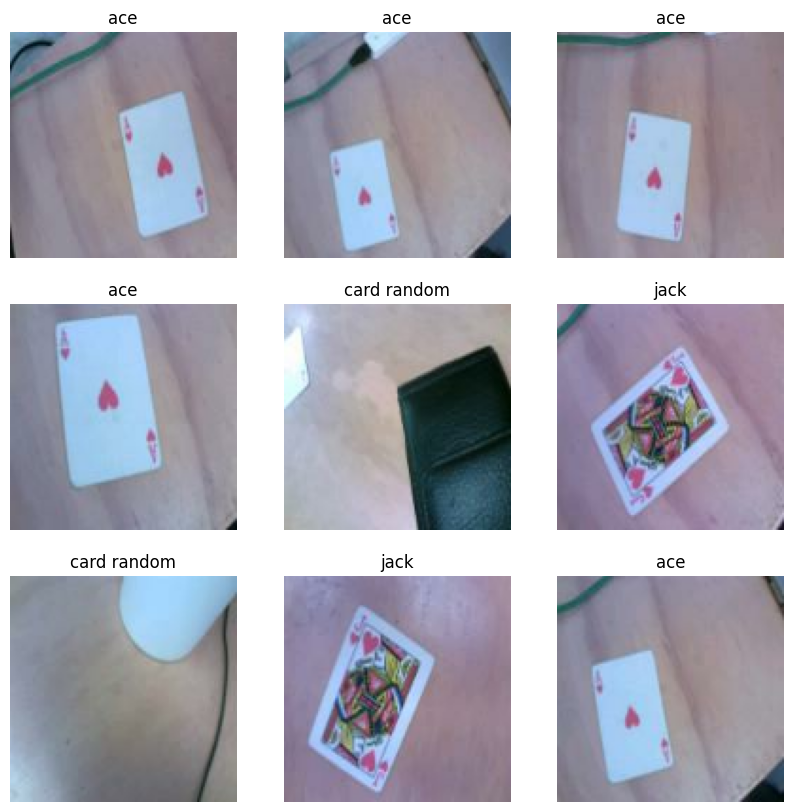

 627/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9826 - loss: 0.0591

 664/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9826 - loss: 0.0593

 700/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9825 - loss: 0.0594

 736/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9825 - loss: 0.0596

 772/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9825 - loss: 0.0597

 808/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9824 - loss: 0.0598

 844/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9824 - loss: 0.0599

 881/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9824 - loss: 0.0600

 918/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9824 - loss: 0.0600

 956/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9823 - loss: 0.0601

 993/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9823 - loss: 0.0602

1030/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9823 - loss: 0.0603

1067/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9823 - loss: 0.0604

1105/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9823 - loss: 0.0605

1143/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9822 - loss: 0.0606

1181/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0606

1218/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0607

1256/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0608

1295/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0608

1334/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0609

1373/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0609

1412/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0610

1451/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0610

1489/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0611

1528/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0611

1566/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0612

1603/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0612

1641/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0613

1679/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0613

1718/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0614

1756/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0614

1795/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0614

1833/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9820 - loss: 0.0615

1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9820 - loss: 0.0615

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9820 - loss: 0.0615 - val_accuracy: 0.9797 - val_loss: 0.0668


In [2]:
batch_size = 58
img_height = 120
img_width = 120


train_ds = tf.keras.utils.image_dataset_from_directory(
  "images/",
  #color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "images/",
  #color_mode='grayscale',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



# print info on the classes in the dataset
class_names = train_ds.class_names
num_classes = len(class_names)
print("number of classes:", num_classes)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(3):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [3]:
image_list = []  # Initialize an empty list to store the images
label_list = []  # Initialize an empty list to store the labels

for images, labels in val_ds:  # Take the first batch

    for i in range(len(images)):
        image_list.append(images[i].numpy())  # Convert to NumPy and store in the list
        label_list.append(labels[i].numpy())  # Convert to NumPy and store in the list

# Convert the list of NumPy arrays into a single NumPy array

image_array = np.array(image_list)
test_labels = np.array(label_list)

# Now apply astype and normalization
test_images = image_array.astype(np.float32) / 255.0


image_list = []  # Initialize an empty list to store the images
label_list = []  # Initialize an empty list to store the labels

for images, labels in train_ds:  # Take the first batch
    for i in range(len(images)):
        image_list.append(images[i].numpy())  # Convert to NumPy and store in the list
        label_list.append(labels[i].numpy())  # Convert to NumPy and store in the list

# Convert the list of NumPy arrays into a single NumPy array

image_array = np.array(image_list)
train_labels = np.array(label_list)

# Now apply astype and normalization
train_images = image_array.astype(np.float32) / 255.0

In [4]:
image_list = []  # Initialize an empty list to store the images
label_list = []  # Initialize an empty list to store the labels

for images, labels in train_ds:  # Take the first batch
    for i in range(len(images)):
        image_list.append(images[i].numpy())  # Convert to NumPy and store in the list
        label_list.append(labels[i].numpy())  # Convert to NumPy and store in the list

# Convert the list of NumPy arrays into a single NumPy array

image_array = np.array(image_list)
train_labels = np.array(label_list)

# Now apply astype and normalization
train_images = image_array.astype(np.float32) / 255.0

first_image = train_images[0]
print(np.min(first_image), np.max(first_image))

0.2882355 0.99411756


In this step we will do a little data augmentation so that the model does not overfit

/home/brickman/miniconda3/envs/openmv_train/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


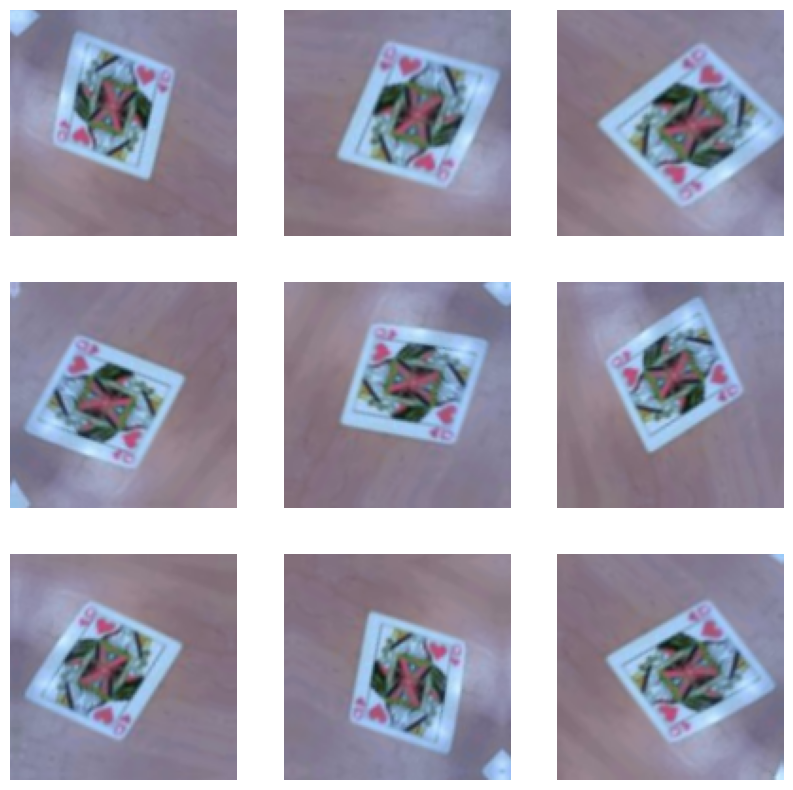

In [5]:
# Augment training data

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.1),
  ]
)


# Visualize Change
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Let's set up our model architecture and decide whether we want to use transfer learning or build the model from scratch. Transfer learning may include more overhead for the edge device but is better with less data, making it faster to build and train.

Choose whether you want to use transfer learning by setting the `transfer_learning` parameter to `True` or `False`.

In [6]:

transfer_learning = True

if transfer_learning:
    # Load the pre-trained MobileNetV2 model (excluding the top classification layer)
    base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                                   include_top=False,  # Do not include the final classification layer
                                                   weights='imagenet')  # Use weights pre-trained on ImageNet
    
    base_model.trainable = False  # Freeze the base model so its weights won't be updated during training
    
    # Create the model
    model = Sequential([
        data_augmentation,
        base_model,  # Add the pre-trained MobileNetV2
        layers.GlobalAveragePooling2D(),  # Use global average pooling instead of flattening
        layers.Dense(128, activation='relu'),  # Add a fully connected layer
        layers.Dropout(0.2),  # Dropout to reduce overfitting
        layers.Dense(num_classes, name="outputs", activation='softmax')  # Final classification layer (for 10 classes)
    ])

else:
    model = Sequential([
      layers.InputLayer(input_shape(img_height, img_width, 3), batch_size=1),  # Proper InputLayer with batch_size=1
      data_augmentation,
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(24, activation='relu'),
      layers.Dense(48, activation='relu'),
      layers.Dense(num_classes, name="outputs", activation='softmax')
    ])


# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# give a nice summary of the model architecture
model.summary()

/tmp/ipykernel_183705/819969002.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Training Model

Now that we have setup are model's architecture lets train our model

In [7]:
epochs = 100
history = model.fit(
  train_images,
  train_labels,
  epochs=epochs,
  validation_data=(test_images, test_labels)
)

Epoch 1/100


/home/brickman/miniconda3/envs/openmv_train/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1726358205.306692  183937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358205.324593  183937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358205.325744  183937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358205.333117  183937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358205.335023  183937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358205.336955  183937 gpu_timer.cc:114]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2612 - loss: 1.8706

W0000 00:00:1726358205.828916  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358205.830185  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358205.831285  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358205.832810  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358205.834075  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358205.835249  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358205.836424  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358205.837551  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358205.838683  183938 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - accuracy: 0.2825 - loss: 1.8092 - val_accuracy: 0.6316 - val_loss: 1.1862
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7027 - loss: 0.8444 - val_accuracy: 0.6842 - val_loss: 0.7438
Epoch 3/100


W0000 00:00:1726358206.562545  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358206.563675  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358206.564774  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358206.566414  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358206.567737  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358206.568925  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358206.570115  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358206.571239  183938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726358206.572357  183938 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8151 - loss: 0.5694 - val_accuracy: 0.8947 - val_loss: 0.3863
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8979 - loss: 0.2576 - val_accuracy: 0.7895 - val_loss: 0.4602
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8926 - loss: 0.3560 - val_accuracy: 0.7368 - val_loss: 0.5103
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9562 - loss: 0.1800 - val_accuracy: 0.7895 - val_loss: 0.4768
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9431 - loss: 0.1420 - val_accuracy: 0.7895 - val_loss: 0.3609
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9147 - loss: 0.2117 - val_accuracy: 0.8947 - val_loss: 0.3111
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9406 - loss: 0.1823 - val_accuracy: 0.8421 - val_loss: 0.3364
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9431 - loss: 0.1304 - val_accuracy: 0.7895 - val_loss: 0.4343
Epo

## Visualize training results
Create plots of the loss and accuracy on the training and validation sets:

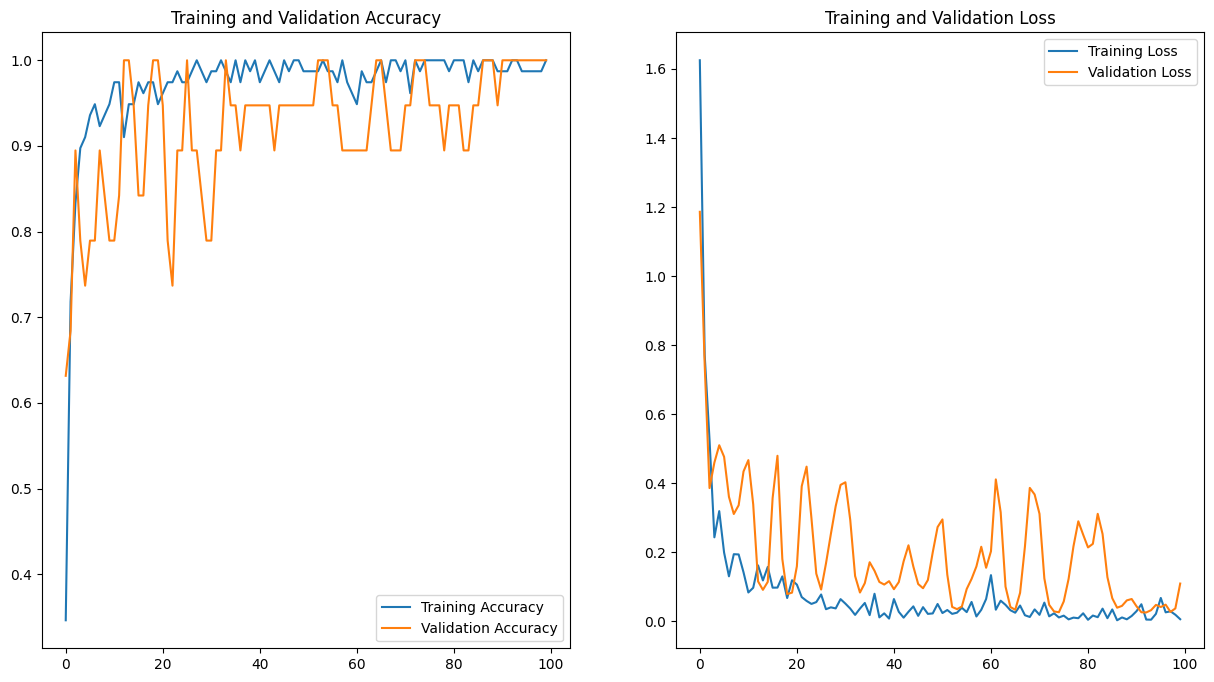

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Convert to a TensorFlow Lite model

### Convert using integer-only quantization

To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a [`RepresentativeDataset`](https://www.tensorflow.org/api_docs/python/tf/lite/RepresentativeDataset). This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.)
To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.


To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with some additional parameters:

In [9]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter._experimental_disable_per_channel_quantization_for_dense_layers = True

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp9hfvsdq2/assets


INFO:tensorflow:Assets written to: /tmp/tmp9hfvsdq2/assets


Saved artifact at '/tmp/tmp9hfvsdq2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133425880675632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133425874501152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133425874497456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133425874500272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133425874498336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133425874500800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133425844427360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133425844427008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133425844424544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133425844427184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1334258444

/home/brickman/miniconda3/envs/openmv_train/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1726358222.705633  183705 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1726358222.705653  183705 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


The internal quantization remains the same as above, but you can see the input and output tensors are now integer format:


In [10]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Now you have an integer quantized model that uses integer data for the model's input and output tensors, so it's compatible with integer-only hardware such as the [Edge TPU](https://coral.ai).

### Save the models as files

You'll need a `.tflite` file to deploy your model on other devices. So let's save the converted model to a file and then load it when we run inferences below.

In [11]:
import pathlib

tflite_models_dir = pathlib.Path("models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

2876048

## Run the TensorFlow Lite model

Now we'll run inferences using the TensorFlow Lite [`Interpreter`](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) to confirm our model's accuracy.

First, we need a function that runs inference with the model and images, and then return the predictions:


In [12]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]


  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
      
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]


    predictions[i] = output.argmax()

  return predictions


### Testing the model on one image


Now we'll test the performance of the model.

Let's create another function to print our predictions:

In [13]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 18

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])


  plt.imshow(test_images[test_image_index])
  template = " Model \n True: {true}, Predicted: {predict}"
  _ = plt.title(template.format(true= str(class_names[test_labels[test_image_index]]), predict=str(class_names[predictions[0]])))
  plt.grid(False)

And test the model on an image:

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


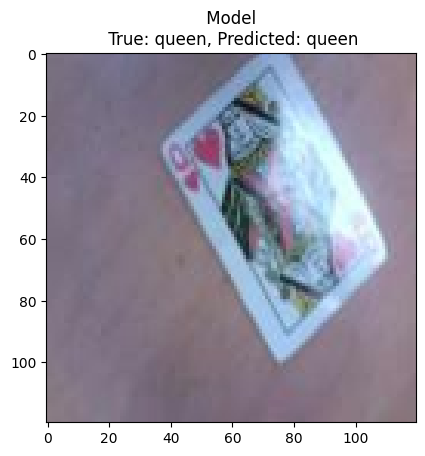

In [14]:
test_model(tflite_model_quant_file, test_image_index)

### Evaluate the model on all images

Now let's run the model using all the test images we loaded at the beginning:

In [15]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

Evaluate the model:

In [16]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 89.4737% (Number of test samples=19)
